<a href="https://colab.research.google.com/github/KarynaSam/Python-DS/blob/main/HW_9_keras_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету fasion_mnist

Імпорти та завантаження датасету

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=746470249cbd565e50246a7f00dd22040fe610f754b6b7293d81db558a44ab50
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
import math
import numpy as np
import os
import random
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import to_categorical

import wandb
from wandb.keras import WandbMetricsLogger

Підключимо незалежний монітор для тривалого збіру аналітики

In [3]:
# Задамо константи і може в подальшому реалізуємо підбір
num_classes = 10
num_features = 28 * 28

lr = 0.001
n_epochs = 50
batch_size = 512
validation_split = 0.1
units_1 = 512
units_2 = 256

In [5]:
wandb.init(project="HW_9_keras_fashion_mnist", config={"lr": lr, "n_epochs": n_epochs, "batch_size": batch_size})

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Короткий огляд змісту, підготовка даних для нейромережі

In [6]:
# Завантажимо датасет fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [7]:
# Подивимося розміри
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

In [9]:
# Підготуємо словник для візуалізацій
labels = \
[
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


In [10]:
labels2index = {i: item for i, item in enumerate(labels)}

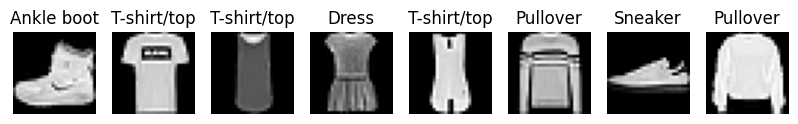

In [11]:
# Візуалізуємо декілька зображень та їх міток
def visualize_images(images, labels, labels2index, num_images=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels2index[labels[i]])
        plt.axis('off')
    plt.show()

num_images_to_visualize = 8
visualize_images(train_images, train_labels, labels2index, num_images=num_images_to_visualize)

Підготуємо дані для моделі, використовуючи універсальний класс Dataset

In [12]:
# Переведемо дані зображень в діапазон [0, 1]
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Перетворимо мітки класів у one-hot кодування
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [13]:
# Перетворимо тренувальні та тестувальні дані у вектори розміром 1 на 784 (кількість пікселів) щоб подати на вхід нейромережі.
# Відповідно, мережа буде сприймати кожен піксель як окремий вхідний параметр для класифікації зображення

train_images = train_images.reshape((-1, 28*28))
test_images = test_images.reshape((-1, 28*28))

In [14]:
train_images.shape, test_images.shape

((60000, 784), (10000, 784))

Реалізуємо нейромережу та навчимо її

In [15]:
# Побудуємо архітектуру мережі: 3 шари з num_features, num_features*2 та num_classes нейронами відповідно
model = Sequential()
model.add(Dense(units_1, activation='relu', input_shape=(num_features,)))
model.add(Dropout(0.2))
model.add(Dense(units_2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Скомпілюємо модель з оптимізатором, функцією втрат та метрикою оцінки
model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [16]:
# Додамо колбек EarlyStopping, щоб зупинити навчання, якщо точність не покращується протягом певної кількості епох
early_stopping_callback = EarlyStopping(monitor='val_categorical_accuracy', patience=5, mode='max', verbose=1)

# Додамо колбек ModelCheckpoint, щоб зберегти найкращу модель за кожним епохом
model_checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', save_best_only=True, verbose=1)

In [17]:
# Навчімо модель
history = model.fit(
    train_images,
    train_labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=validation_split,
    verbose=1,
    callbacks=[early_stopping_callback, model_checkpoint_callback, WandbMetricsLogger()]    )

Epoch 1/50
105/106 [============================>.] - ETA: 0s - loss: 0.6520 - categorical_accuracy: 0.7692
Epoch 1: val_categorical_accuracy improved from -inf to 0.84967, saving model to best_model.h5
106/106 [==============================] - 6s 47ms/step - loss: 0.6509 - categorical_accuracy: 0.7696 - val_loss: 0.4259 - val_categorical_accuracy: 0.8497
Epoch 2/50
  5/106 [>.............................] - ETA: 3s - loss: 0.4248 - categorical_accuracy: 0.8500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


105/106 [============================>.] - ETA: 0s - loss: 0.4155 - categorical_accuracy: 0.8511
Epoch 2: val_categorical_accuracy improved from 0.84967 to 0.86100, saving model to best_model.h5
106/106 [==============================] - 4s 39ms/step - loss: 0.4153 - categorical_accuracy: 0.8511 - val_loss: 0.3882 - val_categorical_accuracy: 0.8610
Epoch 3/50
105/106 [============================>.] - ETA: 0s - loss: 0.3720 - categorical_accuracy: 0.8648
Epoch 3: val_categorical_accuracy improved from 0.86100 to 0.87400, saving model to best_model.h5
106/106 [==============================] - 3s 32ms/step - loss: 0.3721 - categorical_accuracy: 0.8648 - val_loss: 0.3478 - val_categorical_accuracy: 0.8740
Epoch 4/50
105/106 [============================>.] - ETA: 0s - loss: 0.3393 - categorical_accuracy: 0.8779
Epoch 4: val_categorical_accuracy improved from 0.87400 to 0.87817, saving model to best_model.h5
106/106 [==============================] - 5s 48ms/step - loss: 0.3393 - categori

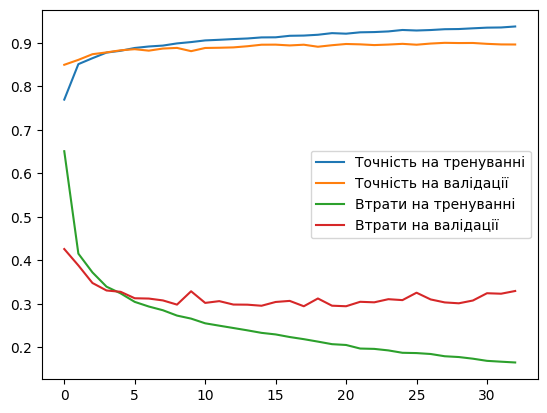

In [18]:
# Графіки для точності та втрат
plt.plot(history.history['categorical_accuracy'], label='Точність на тренуванні')
plt.plot(history.history['val_categorical_accuracy'], label='Точність на валідації')
plt.plot(history.history['loss'], label='Втрати на тренуванні')
plt.plot(history.history['val_loss'], label='Втрати на валідації')
plt.legend()
plt.show()

In [19]:
# Завантажимо найкращу модель з колбека ModelCheckpoint
best_model = Sequential()
best_model.add(Dense(units_1, activation='relu', input_shape=(num_features,)))
best_model.add(Dropout(0.2))
best_model.add(Dense(units_2, activation='relu'))
best_model.add(Dropout(0.2))
best_model.add(Dense(num_classes, activation='softmax'))
best_model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
best_model.load_weights('best_model.h5')

In [22]:
# Оцінимо найкращу модель на тестовому наборі даних
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print(f'Точність на тестовому наборі: {test_accuracy  * 100:.2f}%')

313/313 [==============================] - 1s 2ms/step - loss: 0.3206 - categorical_accuracy: 0.8975
Точність на тестовому наборі: 89.75%


Майже 90%, що близько до бажаного результату

**Проведемо роботу над помилками**

313/313 [==============================] - 2s 4ms/step


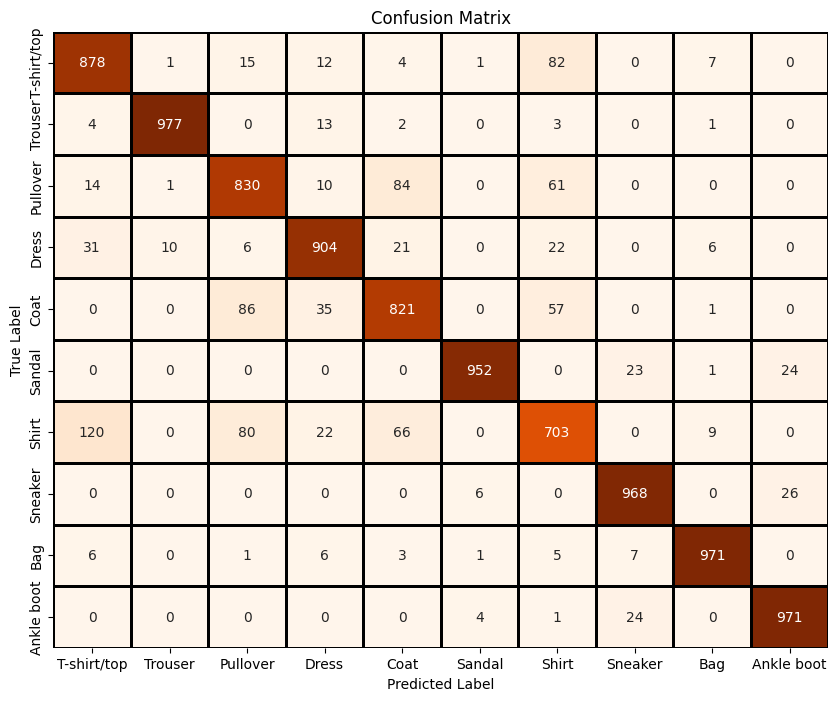

In [23]:
# Побудуємо матрицю плутанини
predictions = best_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, predicted_label in zip(np.argmax(test_labels, axis=1), predicted_labels):
    confusion_matrix[true_label, predicted_label] += 1

# Відобразимо heatmap матриці плутанини з seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix,  fmt="d", annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

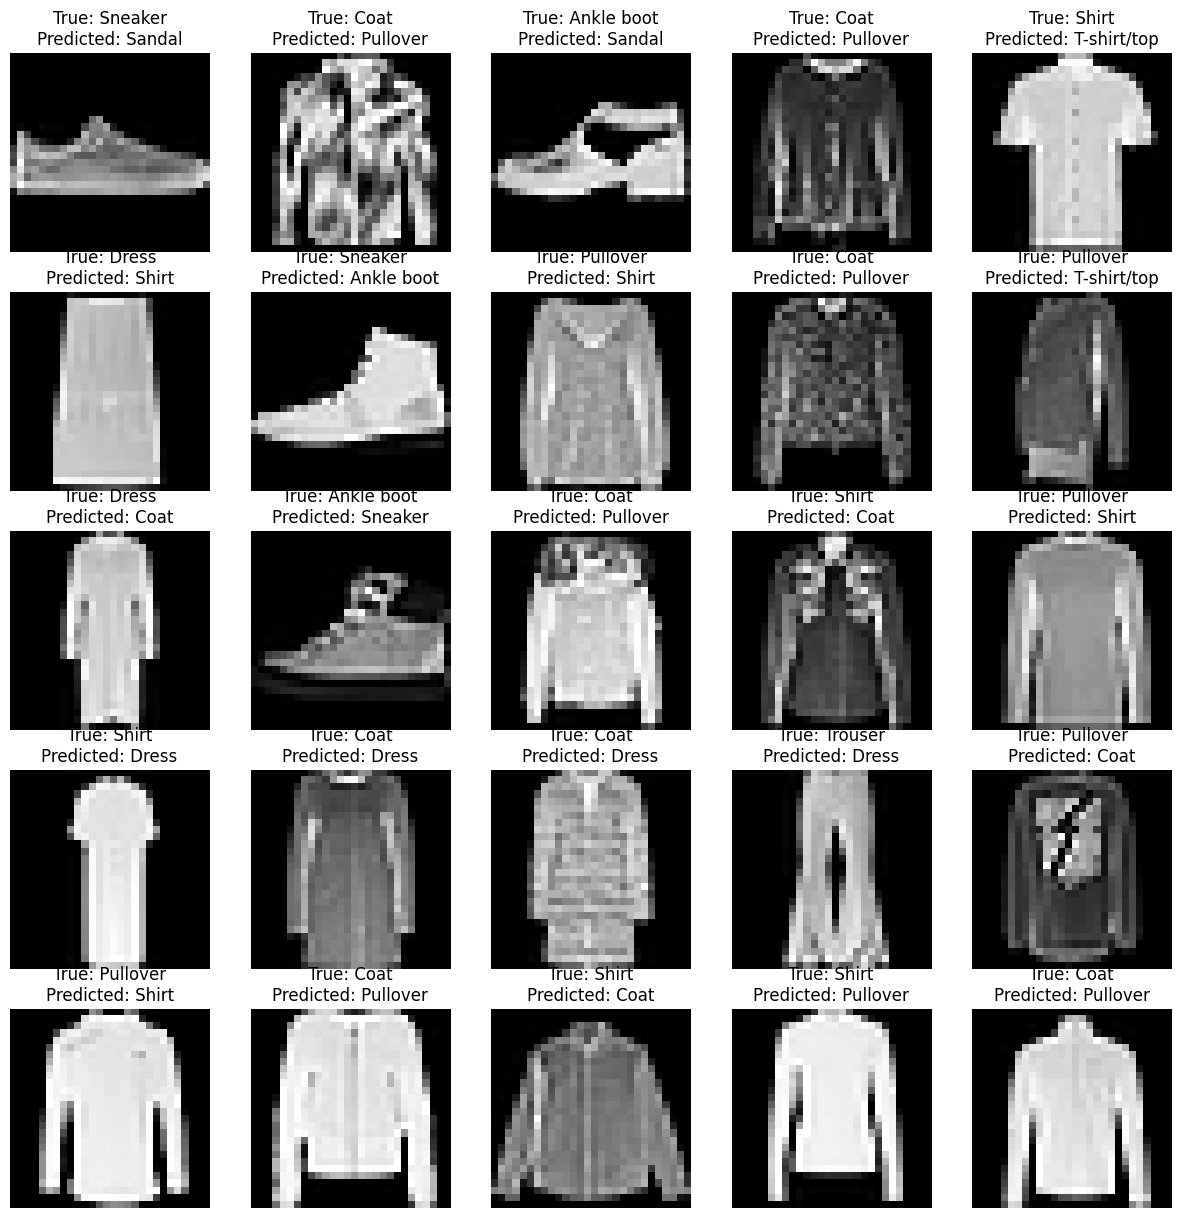

In [24]:
# Знайдемо невірно класифіковані зображення
incorrect_indices = np.where(predicted_labels != np.argmax(test_labels, axis=1))[0]

# Виведемо графік 5x5 зображень невірно класифікованих зображень разом з мітками
plt.figure(figsize=(15, 15))
for i, idx in enumerate(incorrect_indices[:25]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[idx].reshape((28, 28)), cmap='gray')  # Перетворимо назад в форму (28, 28)
    plt.title('True: {}\nPredicted: {}'.format(labels[np.argmax(test_labels[idx])], labels[predicted_labels[idx]]))
    plt.axis('off')
plt.show()

In [25]:
# Загальна кількість невлучних передбачень
incorrect_indices.shape

(1025,)

**Спробуємо побудувати альтернативну модель, використовуючи додатковий вбудований пакет**

In [26]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.4 MB/s eta 0:00:00


In [27]:
from kerastuner.tuners import RandomSearch

Using TensorFlow backend


<ipython-input-27-94471a811b41>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [28]:
# Функція для створення моделі
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units', min_value=10, max_value=units_1, step=10), activation='relu', input_shape=(num_features,)))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('units', min_value=10, max_value=units_2, step=10), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [29]:
# Пошук оптимальних гіперпараметрів
tuner = RandomSearch(
    build_model,
    objective='val_categorical_accuracy',
    max_trials=5,  # Кількість спроб підбору
    directory='keras_tuner_dir',  # Директорія для зберігання результатів
    project_name='fashion_mnist_tuning'  # Назва проекту
)

tuner.search(train_images, train_labels, epochs=n_epochs, validation_split=validation_split)

Trial 5 Complete [00h 10m 23s]
val_categorical_accuracy: 0.8981666564941406

Best val_categorical_accuracy So Far: 0.9021666646003723
Total elapsed time: 00h 39m 36s


In [30]:
# Виведення результатів підбору
tuner.results_summary()

Results summary
Results in keras_tuner_dir/fashion_mnist_tuning
Showing 10 best trials
Objective(name="val_categorical_accuracy", direction="max")

Trial 2 summary
Hyperparameters:
units: 320
dropout: 0.4
learning_rate: 0.0001
Score: 0.9021666646003723

Trial 4 summary
Hyperparameters:
units: 370
dropout: 0.30000000000000004
learning_rate: 0.001
Score: 0.8981666564941406

Trial 3 summary
Hyperparameters:
units: 160
dropout: 0.2
learning_rate: 0.001
Score: 0.8963333368301392

Trial 1 summary
Hyperparameters:
units: 230
dropout: 0.2
learning_rate: 0.01
Score: 0.8356666564941406

Trial 0 summary
Hyperparameters:
units: 120
dropout: 0.30000000000000004
learning_rate: 0.01
Score: 0.828166663646698


In [31]:
# Отримання найкращої моделі
best_model_tuned = tuner.get_best_models(num_models=1)[0]

# Навчання найкращої моделі
history_tuned = best_model_tuned.fit(train_images, train_labels, epochs=n_epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[WandbMetricsLogger()])

Epoch 1/50
106/106 [==============================] - 3s 26ms/step - loss: 0.1775 - categorical_accuracy: 0.9351 - val_loss: 0.2866 - val_categorical_accuracy: 0.9012
Epoch 2/50
106/106 [==============================] - 2s 23ms/step - loss: 0.1705 - categorical_accuracy: 0.9368 - val_loss: 0.2889 - val_categorical_accuracy: 0.9005
Epoch 3/50
106/106 [==============================] - 3s 24ms/step - loss: 0.1682 - categorical_accuracy: 0.9384 - val_loss: 0.2886 - val_categorical_accuracy: 0.9008
Epoch 4/50
106/106 [==============================] - 4s 39ms/step - loss: 0.1679 - categorical_accuracy: 0.9379 - val_loss: 0.2893 - val_categorical_accuracy: 0.9017
Epoch 5/50
106/106 [==============================] - 3s 25ms/step - loss: 0.1657 - categorical_accuracy: 0.9384 - val_loss: 0.2895 - val_categorical_accuracy: 0.9007
Epoch 6/50
106/106 [==============================] - 2s 23ms/step - loss: 0.1646 - categorical_accuracy: 0.9393 - val_loss: 0.2912 - val_categorical_accuracy: 0.900

In [32]:
# Оцінимо найкращу модель на тестовому наборі даних
test_loss_tuned, test_accuracy_tuned = best_model_tuned.evaluate(test_images, test_labels)
print(f'Точність на тестовому наборі: {test_accuracy_tuned}')

313/313 [==============================] - 2s 5ms/step - loss: 0.3252 - categorical_accuracy: 0.9016
Точність на тестовому наборі: 0.9016000032424927


Візуалізація запусків на моніторі wandb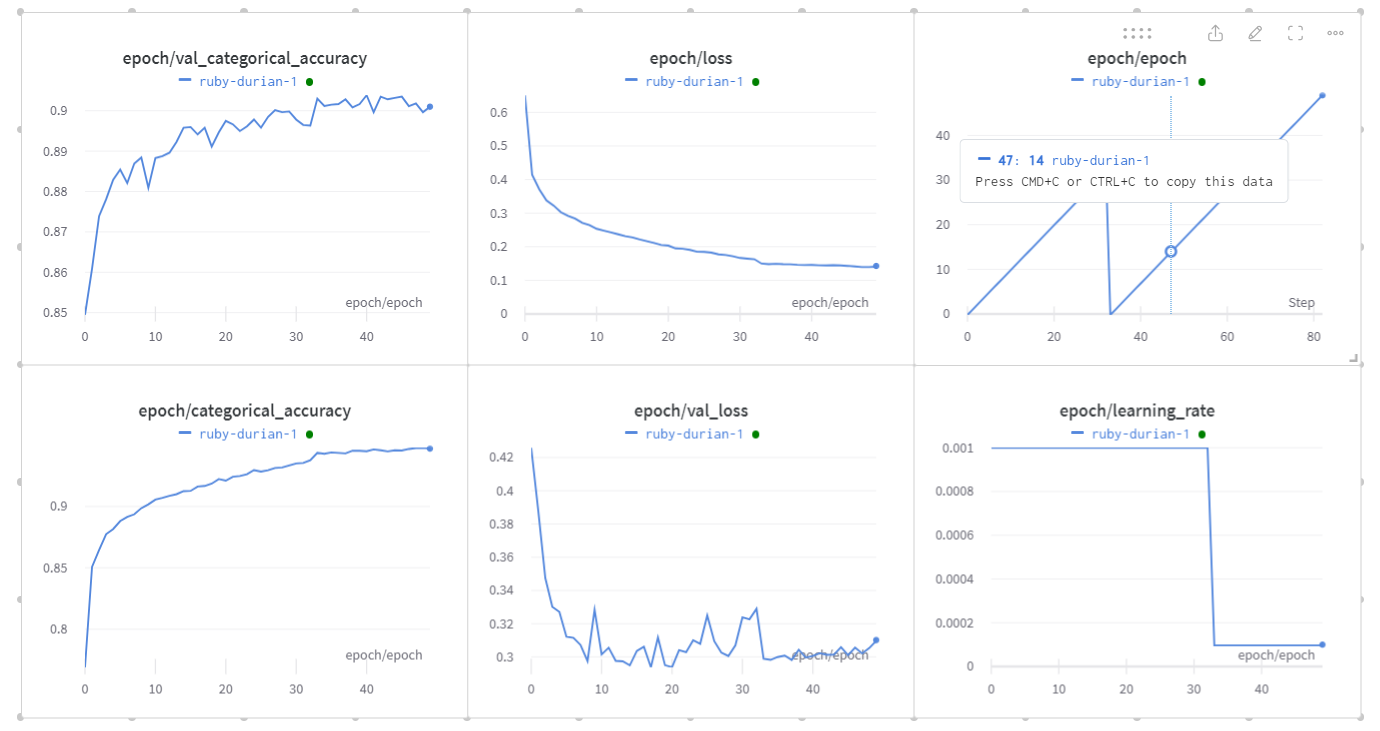

Висновки:
Побудована нейромережа після підбору параметрів видає точність в 90% на тестових даних.